# Introduction to Data Science – Homework 8
*COMP 5360 / MATH 4100, University of Utah, http://datasciencecourse.net/*

Due: Friday, April 3, 11:59pm.

In this homework, you will use clustering, principal component analysis, regular expressions, and natural language processing. 

## Your Data
First Name: Greg 
<br>
Last Name: Lee
<br>
E-mail: u0890227@utah.edu
<br>
UID: u0890227
<br>

In [1]:
# imports and setup 

import pandas as pd
import numpy as np

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn import tree, svm, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

from sklearn.cluster import DBSCAN

from sklearn.decomposition import PCA 

import nltk
from nltk.corpus import stopwords

import re

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)
plt.style.use('ggplot')

## Part 1: Analyze US Crime data

We'll analyze a dataset describing 1973 violent crime rates by US State. The crimes considered are assault, murder, and rape. Also included is the percent of the population living in urban areas.

The dataset is available as *USarrests.csv*. The dataset has 50 observations (corresponding to each state) on 4 variables: 
1. Murder: Murder arrests (per 100,000 residents)
2. Assault: Assault arrests (per 100,000 residents)
3. UrbanPop: Percent urban population
4. Rape: Rape arrests (per 100,000 residents)


You can read more about the dataset [here](https://stat.ethz.ch/R-manual/R-devel/library/datasets/html/USArrests.html). 

Our goal will be to use unsupervised methods to understand how violent crimes differ between states. 

### Task 1.1 Import the data and perform some preliminary exploratory analysis. 
Use the *read_csv* pandas function to import the data as a dataframe. 

Plot a scatterplot matrix of the data. Explore basic statistics of the data. Write a few sentences describing how the variables are correlated. 

In [16]:
#Load that data 
arrests_df = pd.read_csv('USarrests.csv').rename(columns = {'Unnamed: 0':'State'})
arrests_df.head(3)

,State,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0


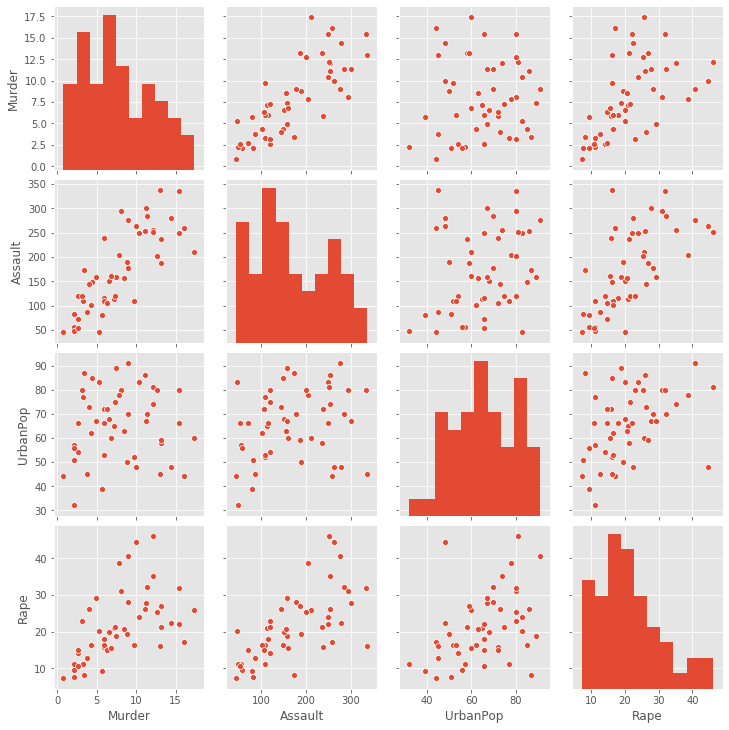

In [17]:
#Scatterplot: 
sns.pairplot(arrests_df);

In [18]:
#Any NaN's?
arrests_df.isna().sum()

State       0
Murder      0
Assault     0
UrbanPop    0
Rape        0
dtype: int64

In [19]:
#Basic Stats
arrests_df.describe()

,Murder,Assault,UrbanPop,Rape
count,50.00000,50.000000,50.000000,50.000000
mean,7.78800,170.760000,65.540000,21.232000
std,4.35551,83.337661,14.474763,9.366385
min,0.80000,45.000000,32.000000,7.300000
25%,4.07500,109.000000,54.500000,15.075000
50%,7.25000,159.000000,66.000000,20.100000
75%,11.25000,249.000000,77.750000,26.175000
max,17.40000,337.000000,91.000000,46.000000


**Data Description:**
1. Overall the count is 50. This makes sense as this data is averaged per state.
2. The average number of murders, assualts, urban population and rapes is 7.78, 170.76, 65.54 and 21.23 respectively. 
3. Standard deviation is highest for assualt and lowest for murder. 
4. Note: Urban Pop is a percentage while the other three columns represent rates per 100,000 residents
5. Urban population has the most "normal" population based upon the histograms while rape and murder are skewed right. 
6. Rape has decent positive correlation Murder Assault and UrbanPop
7. Assualt is highly correlated with murder


### Task 1.2 - Cluster Heat Map

Generate a [cluster heat map](https://seaborn.pydata.org/generated/seaborn.clustermap.html) with a dendrogram using seaborn (see lecture). Be sure to standardize the dataset using the `standard_scale=1` parameter.

Describe any patterns you see.

In [20]:
state = arrests_df.pop("State")

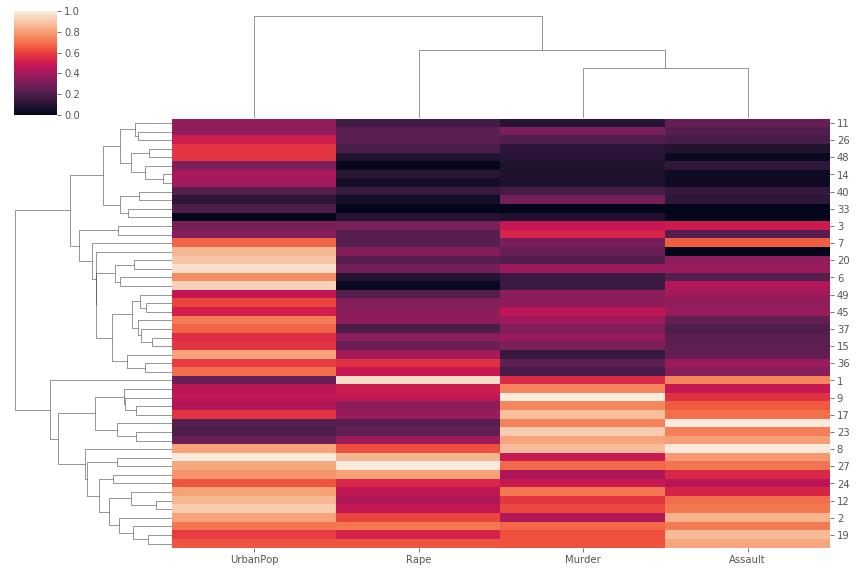

In [21]:
sns.clustermap(arrests_df,
               figsize=(12, 8),
              standard_scale=1)

**Your Interpretation**:

There appears to be a good seperation between the data to seperate those with lower crime incidence and higher crime incidence as evident by the color seperation between the row clusters. Furthermore, it appears that lower urban populations cluster with lower rates of rape, murder and assault. The opposite is true with higher urban populations. Perhaps the most intresting cluster are the two seperations which define the middle. If ranked clusters from 1-4 from top of graph to bottom, this would be clusters two and three. Two seems to represent those ares which have high urban population but low crime rates while the third represents areas where urban population rates are low, but murder and assault remain high.

### Task 1.3 Visualize the data using PCA

Complete the following steps:
1. Scale the dataset using the *scale* function of the sklearn.preprocessing library. 
+ Calculate the principal components of the dataset. 
+  Store the principal components in a pandas dataframe. 
+ Plot a scatterplot of PC1 and PC2. Using the matplotlib function *annotate*, use the state names as markers (instead of dots).
+ Print the explained variance ratio of the PCA. Plot the explained variance ratio of the PCA. Interpret these values. Is it reasonable to reduce the four dimensional space to two dimensions using PCA? 

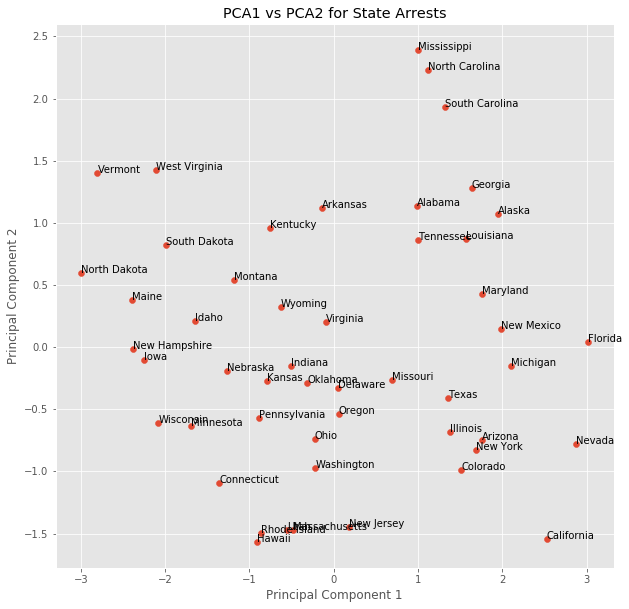

In [22]:
# Scale the Data
s_arrests_df = scale(arrests_df)

#Perform PCA
pca_model = PCA()
s_pca_df = pd.DataFrame(pca_model.fit_transform(s_arrests_df))

#Plot
plt.scatter(s_pca_df[0], s_pca_df[1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

for i, states in enumerate(state):
    plt.annotate(states, (np.array(s_pca_df[0])[i], np.array(s_pca_df[1])[i]))

plt.title('PCA1 vs PCA2 for State Arrests')
plt.show()

In [23]:
#Print the variance o
pca_model.explained_variance_ratio_

array([0.62006039, 0.24744129, 0.0891408 , 0.04335752])

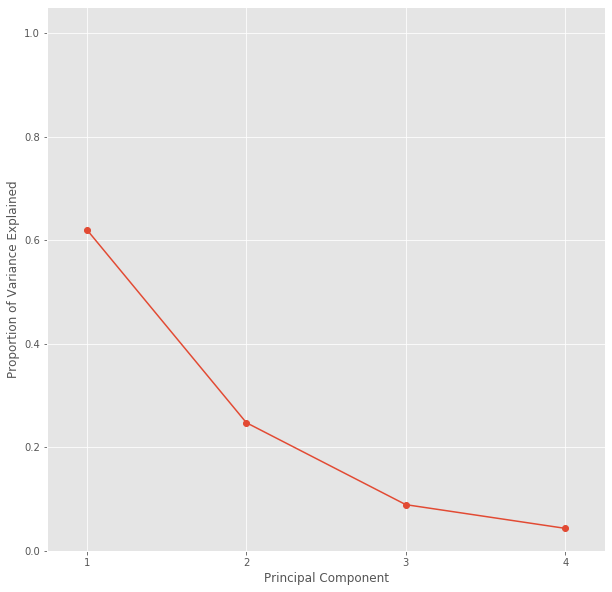

In [24]:
plt.plot([1,2,3,4], pca_model.explained_variance_ratio_, '-o')

plt.ylabel('Proportion of Variance Explained')
plt.xlabel('Principal Component')
plt.xlim(0.75,4.25)
plt.ylim(0,1.05)
plt.xticks([1,2,3,4])
plt.show()

**Your description:**
<br>
PCA of the arrests dataset results in four principle components. The first explains 62% of the variance within the data. Adding the second yields 86.7% of the variance explained. The last two principle components make up 8.9% and 4.3% of the variance. If one was to pull only the first two principal components, they would retain a high amount of variance. Depending on the noise within the dataset, this may still yield accurate and valid results. Where the finer details truly matter, and the dataset is not large, all componenets should be retained. 

### Task 1.4 k-means cluster analysis

1. Using k-means, cluster the states into four clusters. Use the scaled dataset. Which states belong to which clusters?
+ Vary k and find the *best* value. Describe wow do you determine *best*? 
+ Use the principal components to plot the best clustering. Again label each point using the state name and this time color the states according to the clustering. Is the PCA plot consistent with the clustering?


In [25]:
# Your code here
clusters = KMeans(n_clusters=4).fit_predict(s_arrests_df)
pd.DataFrame({'State':state,'Clusters':clusters})

,State,Clusters
0,Alabama,2
1,Alaska,0
2,Arizona,0
3,Arkansas,2
4,California,0
5,Colorado,0
6,Connecticut,3
7,Delaware,3
8,Florida,0
9,Georgia,2


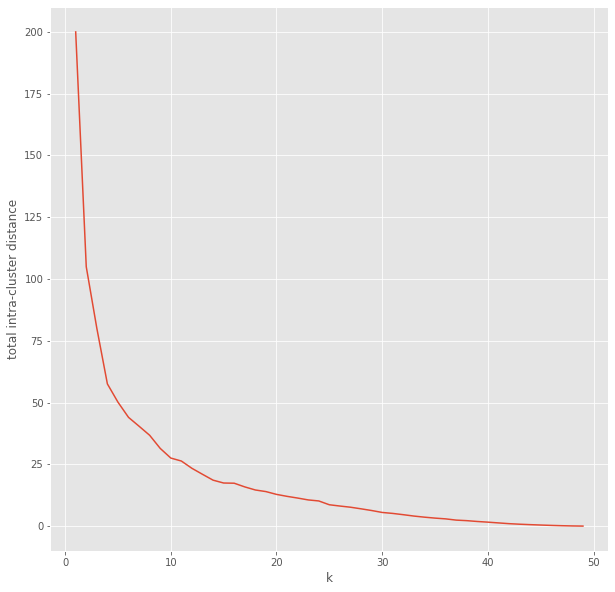

In [26]:
ks = range(1,50)
scores = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit_predict(s_arrests_df)
    scores.append(-model.score(s_arrests_df))

plt.plot(ks, scores)
plt.ylabel('total intra-cluster distance')
plt.xlabel('k')
plt.show()

**Interpretation for best K:** 

Based upon the plot of the intra-cluster distance, I will use 10 clusters as the slope significantly decreases after this point in the graph. Overall, this value represents the total squared Euclidean distance from each point to the center of it's assigned cluster. Herein, we choose 10 as the distance only improves slightly with introduction of more clusters. Additionally, 10 clusters is still reasonably easy to visually analyze!

In [27]:
state

0            Alabama
1             Alaska
2            Arizona
3           Arkansas
4         California
5           Colorado
6        Connecticut
7           Delaware
8            Florida
9            Georgia
10            Hawaii
11             Idaho
12          Illinois
13           Indiana
14              Iowa
15            Kansas
16          Kentucky
17         Louisiana
18             Maine
19          Maryland
20     Massachusetts
21          Michigan
22         Minnesota
23       Mississippi
24          Missouri
25           Montana
26          Nebraska
27            Nevada
28     New Hampshire
29        New Jersey
30        New Mexico
31          New York
32    North Carolina
33      North Dakota
34              Ohio
35          Oklahoma
36            Oregon
37      Pennsylvania
38      Rhode Island
39    South Carolina
40      South Dakota
41         Tennessee
42             Texas
43              Utah
44           Vermont
45          Virginia
46        Washington
47     West V

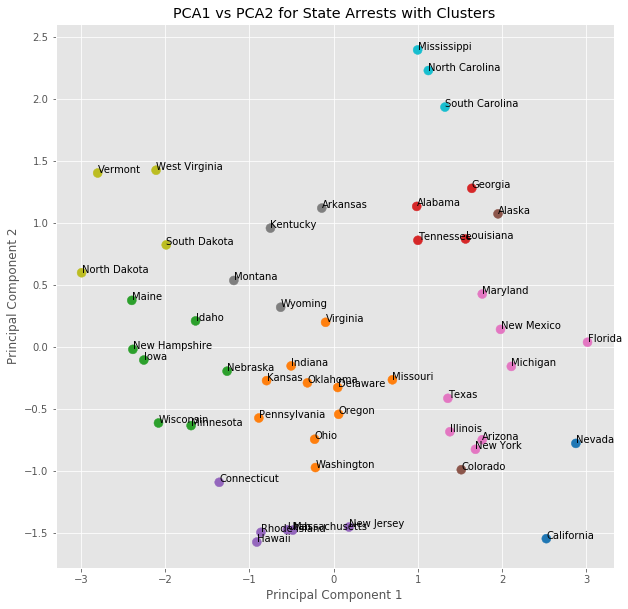

In [28]:
# your code here
clusters = KMeans(n_clusters=10).fit_predict(s_arrests_df)

#Plot
plt.scatter(s_pca_df[0], s_pca_df[1],c=clusters,cmap='tab10',s=80)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

for i, states in enumerate(state):
    plt.annotate(states, (np.array(s_pca_df[0])[i], np.array(s_pca_df[1])[i]))

plt.title('PCA1 vs PCA2 for State Arrests with Clusters')
plt.show()

**Interpretation for PCA and K-Means**:

Overall, 10 clusters fits the data pretty well, although it may be a bit overzealous in the total number of clusters. Perhaps most intersting to me, is the clustering of Utah with Hawaii, Washington, Oregon and Ohio while Colorado, Nevada and California are in their own seperate clusters. Visually, this showcases some interesting trends within the data, but fewer clusters may be more optimal.  

### Task 1.5 Hierarchical cluster analysis

1.  Using hierarchical clustering with complete linkage and Euclidean distance, cluster the states into four clusters. Which states belong to which clusters? 
2. Visualize your cluster results on top of the first two principle components, as before.
3. Do you get similar results as for k-means? Can you see trends between the states?

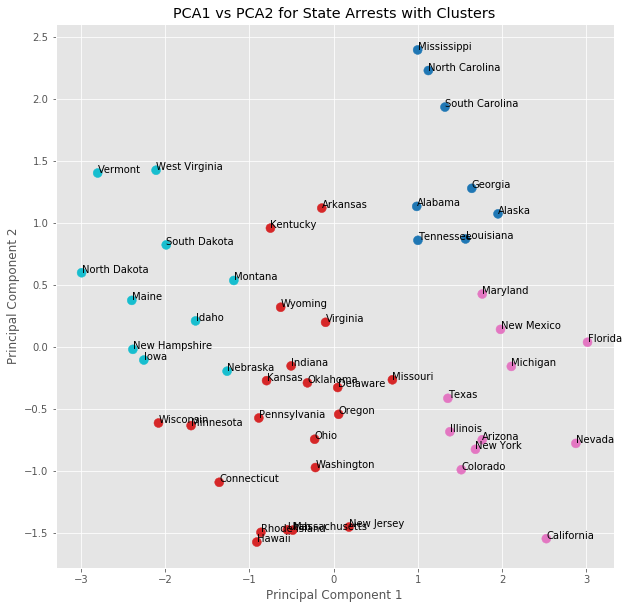

In [29]:
# Your code here
hie_cluster = AgglomerativeClustering(linkage="complete", affinity='euclidean', n_clusters=4)
clusters = hie_cluster.fit_predict(s_pca_df)


#Plot
plt.scatter(s_pca_df[0], s_pca_df[1],c=clusters,cmap='tab10',s=80)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

for i, states in enumerate(state):
    plt.annotate(states, (np.array(s_pca_df[0])[i], np.array(s_pca_df[1])[i]))

plt.title('PCA1 vs PCA2 for State Arrests with Clusters')
plt.show()

**Interpretation:** 

These clusters seem to fit the data a bit better than the k-means clustering as there is less odd seperation, from a visual standpoint. Some trends which seem to stand out: 

1. Blue is mostly southern countries, aside from Alaska. 
2. Light Blue is mostly states with small populationas, which are predominantly white. There is an odd mix of locations within this cluster. 
3. the red and pink clusters are perhaps the most interesting. Red seems to cover a wide range of different types of states. It seems this might be better split with one more cluster. The pink cluster mostly represents areas of high density population with most large cities (LA, NY, Chicago etc) within this cluster. It is interesting that Nevada makes it into this category!


### Task 1.6 DBSCAN

1.  Using DBSCAN and experiment with different values for $\epsilon$ and min samples. Which states belong to which clusters? 
2. Visualize your cluster results on top of the first two principle components, as before.
3. Do you get similar results as before? Is DBSCAN stable or very sensitive to changes in epsilon for this dataset?

0.5
1


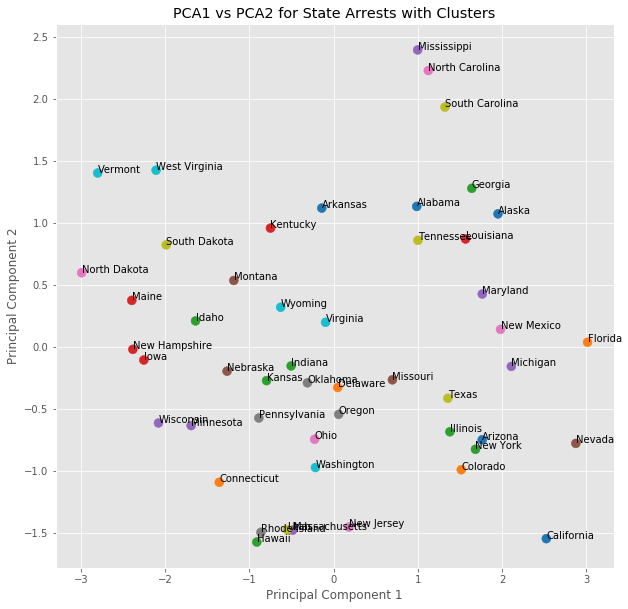

0.5
3


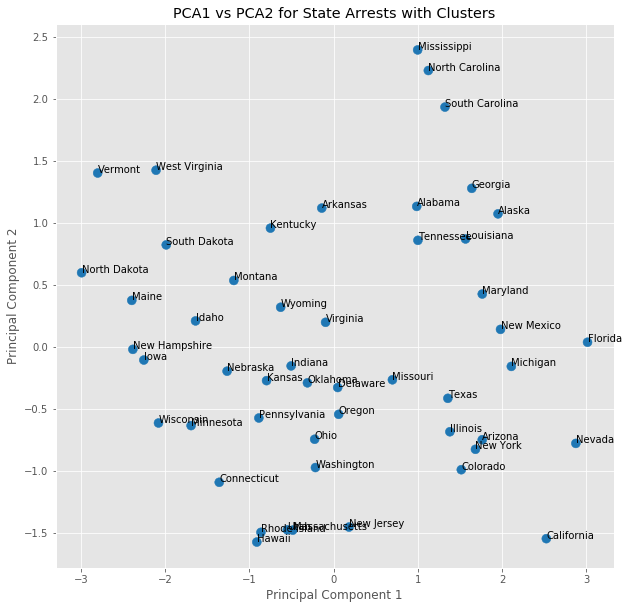

0.5
5


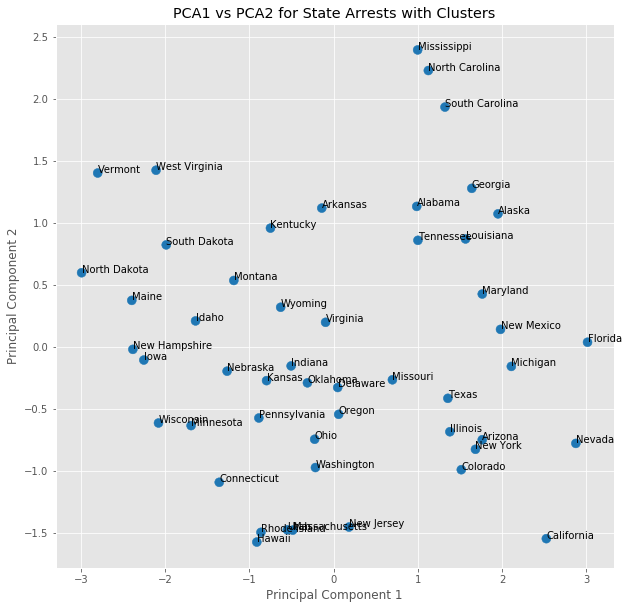

0.75
1


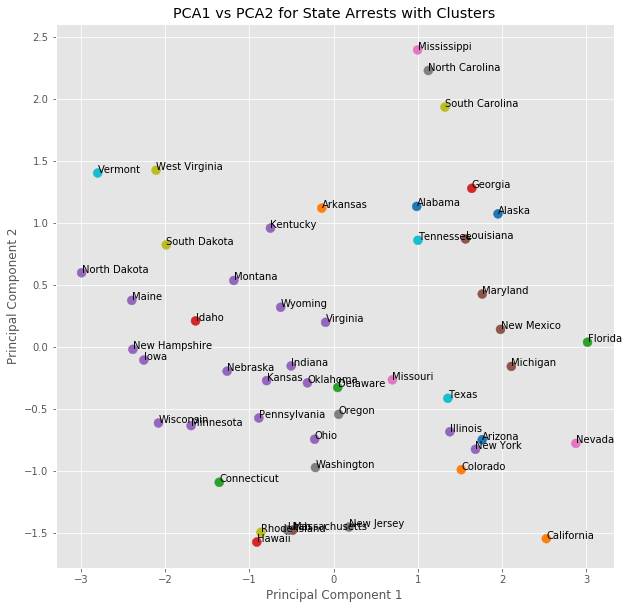

0.75
3


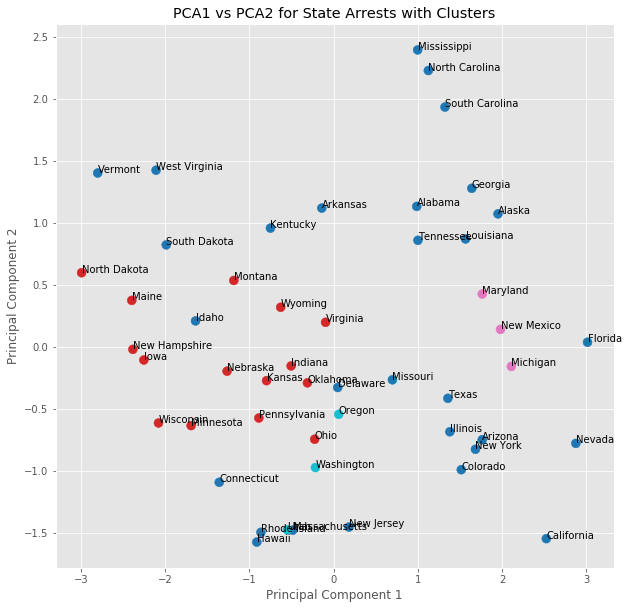

0.75
5


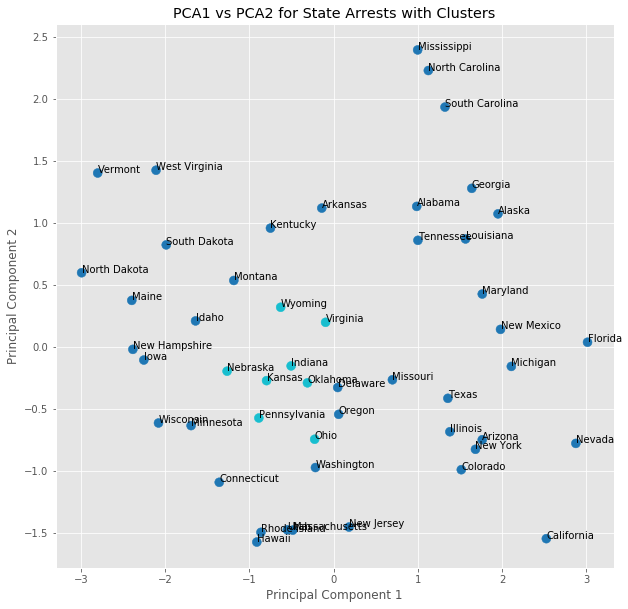

1.0
1


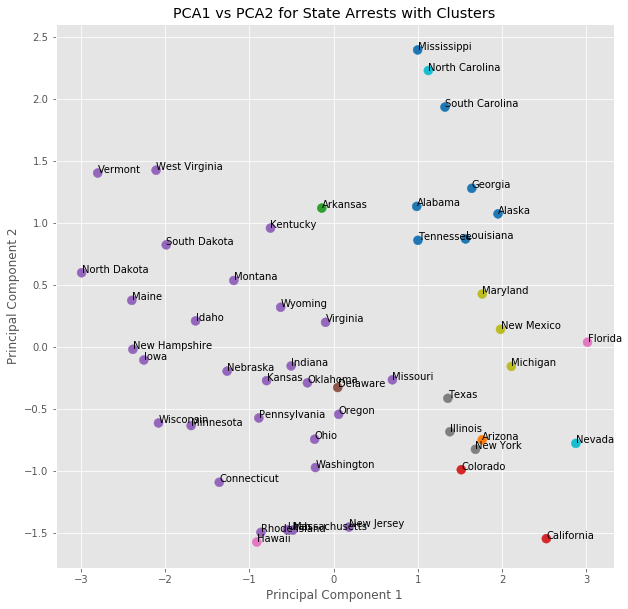

1.0
3


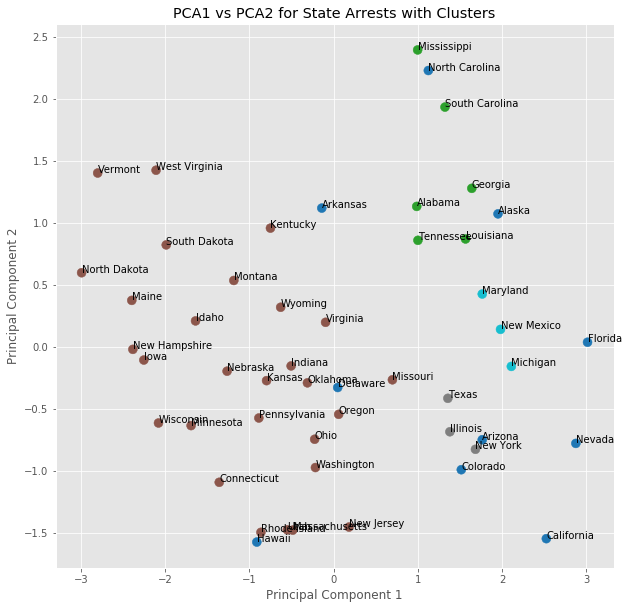

1.0
5


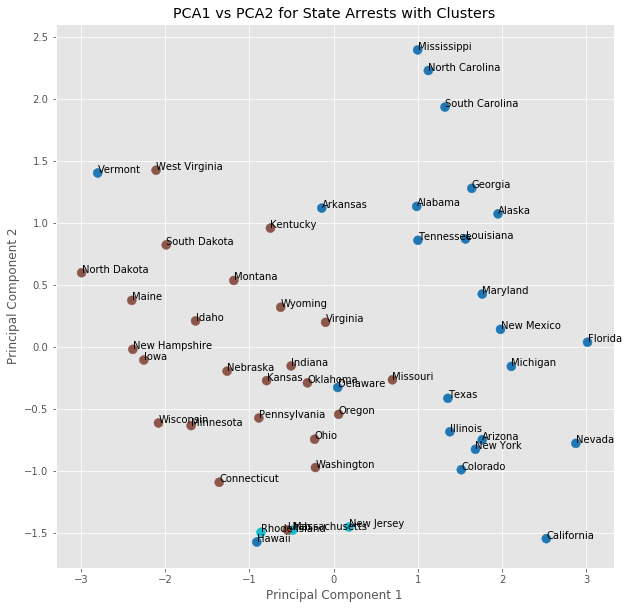

In [57]:
#DBSCAN

ep = [0.5,0.75,1.0]
samp = [1,3,5]

for e in ep:
    for sam in samp:
        print(e)
        print(sam)
        test_model = DBSCAN(eps=e, min_samples=sam)
        cluster = test_model.fit_predict(s_arrests_df)
        
        #Plot
        plt.scatter(s_pca_df[0], s_pca_df[1],c=cluster,cmap='tab10',s=80)
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')

        for i, states in enumerate(state):
            plt.annotate(states, (np.array(s_pca_df[0])[i], np.array(s_pca_df[1])[i]))

        plt.title('PCA1 vs PCA2 for State Arrests with Clusters')
        plt.show()        
        

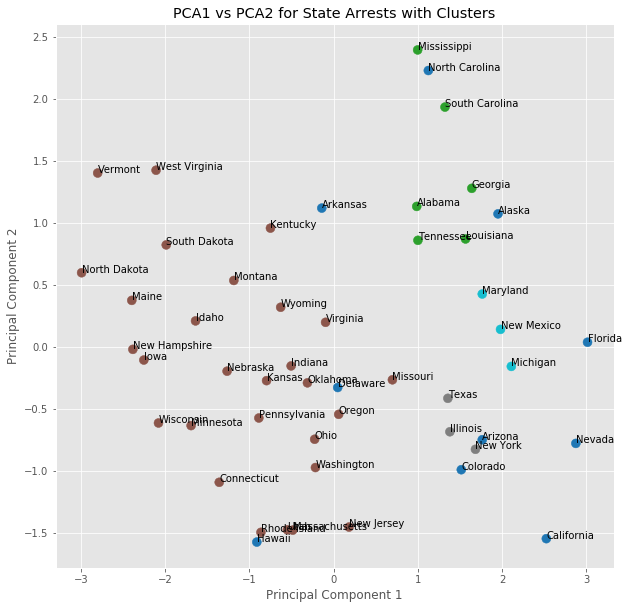

In [58]:
test_model = DBSCAN(eps=1, min_samples=3)
cluster = test_model.fit_predict(s_arrests_df)

#Plot
plt.scatter(s_pca_df[0], s_pca_df[1],c=cluster,cmap='tab10',s=80)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

for i, states in enumerate(state):
    plt.annotate(states, (np.array(s_pca_df[0])[i], np.array(s_pca_df[1])[i]))

plt.title('PCA1 vs PCA2 for State Arrests with Clusters')
plt.show() 

**Your Interpretation**:

Herein, I tried many different combinations of epsilon and min_samples. In the end I settled on 1.0 epsilon and minsamples=3 as this best visually clustered in an understandable way. 

1. In this configuration there are a total of four clusters: here is the breakdown.



In [64]:
pd.DataFrame((state,cluster)).T.rename(columns={'Unnamed 0': 'Clusters'})

,State,Clusters
0,Alabama,0
1,Alaska,-1
2,Arizona,-1
3,Arkansas,-1
4,California,-1
5,Colorado,-1
6,Connecticut,1
7,Delaware,-1
8,Florida,-1
9,Georgia,0


2. See above for results.
3. DBSCAN is very sensitive to changes in episilon. By the end of looking at these graphs, I felt like I was altering DBSCAN until I saw something which made sense. This seems dangerous and non-standardized. Regardless, overall the clustering seems to make some sense. Green represents a few southern states while brown represents the midwest. Grey are places with large cities and blue represents typical states with large populations, typically coastal. 

# 2. Regular Expressions 

Write regular expressions for the following examples that matches the data of the given format and any other reasonable variations thereof. E.g., your regex shouldn't be specific to one URL or one phone number, but should work for all examples of the same format.

**Task 2.1.** Writes a regular expression that extracts the urls out of this string, but only the URLs.

In [17]:
text = """To learn about pros/cons of data science, go to http://datascience.net.\
Alternatively, go to datascience.net/2018/"""
print(text)

To learn about pros/cons of data science, go to http://datascience.net.Alternatively, go to datascience.net/2018/


In [18]:
# Your code here
re.findall(r'[\w:/]+\.[\w/]+', text)

['http://datascience.net', 'datascience.net/2018/']

**Task 2.2.** Write a regular expression that extracts all phone numbers and fax numbers from this text: 

In [19]:
text = """You can reach me at 801-774-4321, or my office at (801) 223 9571 or (801) 223 2522.\ 
Send me a fax at 857 188 7422. We finally made the sale for all 977 giraffes.\
They wanted 225 957 dollars for it."""

In [20]:
# Your code here
re.findall(r'[\d)( -]*([0-9]{3})[\d)( -]*([0-9]{3})[\d)( -]*([0-9]{4})', text)

[('801', '774', '4321'),
 ('801', '223', '9571'),
 ('801', '223', '2522'),
 ('857', '188', '7422')]

**Task 2.3.** Write a regular expression that extracts all opening html tags from this, including `<br />`.

In [21]:
html = "This is <b>important</b> and <u>very</u><i>timely</i><br />. Was this <span> what you meant?</span>"

In [22]:
# Your code here
re.findall(r'<.+?>',html)

['<b>', '</b>', '<u>', '</u>', '<i>', '</i>', '<br />', '<span>', '</span>']

**Task 2.4.** Write a regular expression that extracts all the names of people from the following text. 

In [23]:
text = """Arnold Schwarzenegger was born in Austria. He and Sylvester Stalone used to run a restaurant\
with J. Edgar Hoover."""

In [24]:
# Your code here
re.findall(r'[A-Z][\.]* [A-Z][\w]* [A-Z][\w]+|[A-Z][\w]* [A-Z][\w]+',text)

['Arnold Schwarzenegger', 'Sylvester Stalone', 'J. Edgar Hoover']

**Task 2.5.** Write a regular expression that extracts the text out of all html elements of class important.

In [25]:
text = """Lorem ipsum dolor <b>sit</b> amet, <b class="important">consectetur adipiscing</b> elit,\ 
sed do eiusmod <span id="note">tempor incididunt ut</span> <div>labore <strong class="important">\
et dolore magna</strong> aliqua.</div> Ut enim ad minim veniam, quis n|ostrud exercitation ullamco."""

In [26]:
# Your code here
re.findall(r'class="important".*?>(.*?)<',text)

['consectetur adipiscing', 'et dolore magna']

## 3. NLP: Classifying Newsgroups Articles

Newsgroups were the social media of the 90s. Newsgroups are open discussion forums structured into hierarchies. For example, the following newsgroups cover topics as divers as atheism, computer graphics, and classified ads.  

```
alt.atheism
comp.graphics
comp.os.ms-windows.misc
comp.sys.ibm.pc.hardware
comp.sys.mac.hardware
comp.windows.x
misc.forsale
```

We will be combining machine learning and natural language processing to classify the news articles into these groups. We expect, for example, that the text for a classified ad in `misc.forsale` is different from text in `alt.atheism`. 

We will use the 20 Newsgroups corpus from scikit-learn. The 20 newsgroups dataset comprises around 18,000 newsgroups posts on 20 topics. The general steps we follow are:
1. Load the corpus    
+ Do preprocessing: removal of stopwords, stemming, etc.
+ Vectorize the text
+ Split into training and test sets
+ Train our classifier

Refer to documentation on the [20 newsgroups dataset](https://scikit-learn.org/stable/datasets/index.html#the-20-newsgroups-text-dataset) to learn about the dataset and find out how to download it.
We recommended you use the `subset='all'` parameter to load all the data at once, instead of `subset='train'` and `subset='test'` separately.

**Task 4.1.** Load the dataset.

1. Print the exact number of news articles in the corpus.
2. Print all 20 categories the news articles belong to.

In [2]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='all')

In [3]:
newsgroups_train.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [4]:
print("The total number of new articles in the corpus are: {0}".format(len(newsgroups_train['data'])))

The total number of new articles in the corpus are: 18846


In [5]:
print('These are the total number of categories: {0}'.format(len(newsgroups_train['target_names'])))

These are the total number of categories: 20


### Task 3.2 Classification

Vectorize the data using vectorizers from sklearn. Using these vectors as features and the article category from corpus as labels, train a NaiveBayes classifier to classify the data.

#### Vectorizers

Vectorizes help us to transform text data into features we can use in machine learning. We did the vectorization manually in class, here you will use pre-build vectorizers. 

You should use CountVectorizer and TfidfVectorizer vectorizers from sklearn to vectorize your data. Please refer to documentation on both to learn how to use them.
+ http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
+ http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

Compare the performance of classifiers using both vectorizers. You are encouraged to experiment with different parameters like max_df, min_df, etc. See docs for the meanings.

#### Naive Bayes
**Resources**
1. https://en.wikipedia.org/wiki/Naive_Bayes_classifier
2. https://www.geeksforgeeks.org/naive-bayes-classifiers
3. http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

We will be using Multinomial Naive Bayes from sklearn. Refer to documentation above for how to import the classifier. Then it can be used like any other classifier by using fit and predict functions provided on it.
e.g:

```
clf = MulitnomialNB(alpha = 1)
clf.fit(X_train, Y_train)
y_pred = clf.predict(X_test)
```

Alpha is also known as the smoothing factor and ranges from 0 (no smoothing) to 1 (Laplace Smoothing). You can experiment with different values to see if you get better results. 

In [6]:
#Organize the data: 
text = newsgroups_train['data']
labels = newsgroups_train['target']

In [7]:
# CountVectorizer with preset min and max occurence ratios
COUNT = CountVectorizer(max_df=1.0,min_df=1)
X_COUNT = COUNT.fit_transform(text)
X_COUNT = X_COUNT.toarray()

In [8]:
#TfidfVectorizer with preset min and max occurence ratios
TFIDF = TfidfVectorizer(max_df=1.0,min_df=1)
X_TFIDF = TFIDF.fit_transform(text)
X_TFIDF = X_TFIDF.toarray()

In [9]:
#Compare the output data size:
print("Count Vectorizer Shape: {0} x {1}".format(X_COUNT.shape[0],X_COUNT.shape[1]))
print("Tfidf Vectorizer Shape: {0} x {1}".format(X_TFIDF.shape[0],X_TFIDF.shape[1]))

Count Vectorizer Shape: 18846 x 173762
Tfidf Vectorizer Shape: 18846 x 173762


In [10]:
#Build the Classifier
X = X_COUNT
y = labels

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

#Try the basic settings
mnb_model = MultinomialNB()
mnb_model.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [11]:
#What is the accuracy
y_pred = mnb_model.predict(X_test)
y_pred_train = mnb_model.predict(X_train)

print('Train Accuracy = ', metrics.accuracy_score(y_true = y_train, y_pred = y_pred_train))
print('Test Accuracy = ', metrics.accuracy_score(y_true = y_test, y_pred = y_pred))

Train Accuracy =  0.9231228442557707
Test Accuracy =  0.8602122015915119


In [ ]:
#This is the basic version. Accuracy is not too bad but the model takes forever to train.

In [9]:
#Build the Classifier
X = X_TFIDF
y = labels

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

#Try the basic settings
tfid_mnb_model = MultinomialNB()
tfid_mnb_model.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [10]:
#What is the accuracy
y_pred = tfid_mnb_model.predict(X_test)
y_pred_train = tfid_mnb_model.predict(X_train)

print('Train Accuracy = ', metrics.accuracy_score(y_true = y_train, y_pred = y_pred_train))
print('Test Accuracy = ', metrics.accuracy_score(y_true = y_test, y_pred = y_pred))

Train Accuracy =  0.9239851419474662
Test Accuracy =  0.8535809018567639


Initial run utilizing initial setting yields approximately equal train and test accuracy between Tfidf and count vectorization. As this is a computationally heavy process I plan to only test a few iterations of the following hyperparameters. 

### Modifying the Max and Min

In [11]:
maxy = [1.0,0.75,0.5,0.2,0.1]

In [15]:
miny = [0.00001,0.0001,0.001,0.01]
maxy = [1.0,0.75,0.5,0.2,0.1]
for vals in range(len(maxy)):
    print("min: 0.01 & max: {0}".format(maxy[vals]))
    COUNT = CountVectorizer(max_df=maxy[vals],min_df=0.01)
    X_COUNT = COUNT.fit_transform(text)
    X_COUNT = X_COUNT.toarray()

    X = X_COUNT
    y = labels

    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

    #Try the basic settings
    tfid_mnb_model = MultinomialNB(alpha = 0.1)
    tfid_mnb_model.fit(X_train, y_train)

    #What is the accuracy
    y_pred = tfid_mnb_model.predict(X_test)
    y_pred_train = tfid_mnb_model.predict(X_train)

    print('Train Accuracy = ', metrics.accuracy_score(y_true = y_train, y_pred = y_pred_train))
    print('Test Accuracy = ', metrics.accuracy_score(y_true = y_test, y_pred = y_pred))

min: 0.01 & max: 1.0
Train Accuracy =  0.8172592199522419
Test Accuracy =  0.76657824933687
min: 0.01 & max: 0.75
Train Accuracy =  0.8207747413106925
Test Accuracy =  0.7777188328912467
min: 0.01 & max: 0.5
Train Accuracy =  0.8238259485274608
Test Accuracy =  0.7748010610079575
min: 0.01 & max: 0.2
Train Accuracy =  0.8334438843194482
Test Accuracy =  0.7742705570291777
min: 0.01 & max: 0.1
Train Accuracy =  0.8326479172194216
Test Accuracy =  0.7716180371352785


In [12]:
miny = [0.01,0.001,0.0001]

for vals in range(len(miny)):
    print("max: 0.1 & min: {0}".format(miny[vals]))
    COUNT = CountVectorizer(max_df=0.1,min_df=miny[vals])
    X_COUNT = COUNT.fit_transform(text)
    X_COUNT = X_COUNT.toarray()

    X = X_COUNT
    y = labels

    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

    #Try the basic settings
    tfid_mnb_model = MultinomialNB(alpha = 0.1)
    tfid_mnb_model.fit(X_train, y_train)

    #What is the accuracy
    y_pred = tfid_mnb_model.predict(X_test)
    y_pred_train = tfid_mnb_model.predict(X_train)

    print('Train Accuracy = ', metrics.accuracy_score(y_true = y_train, y_pred = y_pred_train))
    print('Test Accuracy = ', metrics.accuracy_score(y_true = y_test, y_pred = y_pred))

max: 0.1 & min: 0.01
Train Accuracy =  0.8326479172194216
Test Accuracy =  0.7657824933687003
max: 0.1 & min: 0.001
Train Accuracy =  0.9350623507561687
Test Accuracy =  0.8671087533156498
max: 0.1 & min: 0.0001
Train Accuracy =  0.9652427699655081
Test Accuracy =  0.8949602122015915


In [13]:
COUNT = CountVectorizer(max_df=0.5,min_df=0.1)
X_COUNT = COUNT.fit_transform(text)
X_COUNT = X_COUNT.toarray()

X = X_COUNT
y = labels

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

#Try the basic settings
tfid_mnb_model = MultinomialNB(alpha = 0.1)
tfid_mnb_model.fit(X_train, y_train)

#What is the accuracy
y_pred = tfid_mnb_model.predict(X_test)
y_pred_train = tfid_mnb_model.predict(X_train)

print('Train Accuracy = ', metrics.accuracy_score(y_true = y_train, y_pred = y_pred_train))
print('Test Accuracy = ', metrics.accuracy_score(y_true = y_test, y_pred = y_pred))

Train Accuracy =  0.32986203236932876
Test Accuracy =  0.3050397877984085


In [11]:
TFIDF = TfidfVectorizer(max_df=0.8,min_df=0.2)
X_TFIDF = TFIDF.fit_transform(text)
X_TFIDF = X_TFIDF.toarray()

X = X_COUNT
y = labels

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

#Try the basic settings
tfid_mnb_model = MultinomialNB(alpha = 0.1)
tfid_mnb_model.fit(X_train, y_train)

#What is the accuracy
y_pred = tfid_mnb_model.predict(X_test)
y_pred_train = tfid_mnb_model.predict(X_train)

print('Train Accuracy = ', metrics.accuracy_score(y_true = y_train, y_pred = y_pred_train))
print('Test Accuracy = ', metrics.accuracy_score(y_true = y_test, y_pred = y_pred))

Train Accuracy =  0.2596179357919873
Test Accuracy =  0.2363395225464191


### Modifying Alpha: 

In [16]:
#Build the Classifier
X = X_TFIDF
y = labels

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

#Try the basic settings
tfid_mnb_model = MultinomialNB(alpha = 0.5)
tfid_mnb_model.fit(X_train, y_train)

#What is the accuracy
y_pred = tfid_mnb_model.predict(X_test)
y_pred_train = tfid_mnb_model.predict(X_train)

print('Train Accuracy = ', metrics.accuracy_score(y_true = y_train, y_pred = y_pred_train))
print('Test Accuracy = ', metrics.accuracy_score(y_true = y_test, y_pred = y_pred))

Train Accuracy =  0.9486601220482886
Test Accuracy =  0.8689655172413793


In [10]:
#Build the Classifier
X = X_TFIDF
y = labels

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

#Try the basic settings
tfid_mnb_model = MultinomialNB(alpha = 5.0)
tfid_mnb_model.fit(X_train, y_train)

#What is the accuracy
y_pred = tfid_mnb_model.predict(X_test)
y_pred_train = tfid_mnb_model.predict(X_train)

print('Train Accuracy = ', metrics.accuracy_score(y_true = y_train, y_pred = y_pred_train))
print('Test Accuracy = ', metrics.accuracy_score(y_true = y_test, y_pred = y_pred))

Train Accuracy =  0.8372247280445742
Test Accuracy =  0.7843501326259947


Smaller alpha seems to be better!

In [9]:
#Build the Classifier
X = X_TFIDF
y = labels

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

#Try the basic settings
tfid_mnb_model_1 = MultinomialNB(alpha = 0.1)
tfid_mnb_model_1.fit(X_train, y_train)

#What is the accuracy
y_pred = tfid_mnb_model_1.predict(X_test)
y_pred_train = tfid_mnb_model_1.predict(X_train)

print('Train Accuracy = ', metrics.accuracy_score(y_true = y_train, y_pred = y_pred_train))
print('Test Accuracy = ', metrics.accuracy_score(y_true = y_test, y_pred = y_pred))

Train Accuracy =  0.9804324754576811
Test Accuracy =  0.903448275862069


**Conclusion**
It seems the best model I could come up with in a short time, is the final one, which outperformed modulations on the mindf and maxdf. This makes sense as it does not compress the data in any manner. We will proceed with this model for the remainder of the homework. This model achieves 0.98 accuracy on the train set and 0.90 on the test set

### Task 3.3 Removing Stopwords

Now we'll use the NLTK stopword list to improve our data vectors. TfidfVectorizer and CountVectorizer both can take an argument called stop_words. The words passed to this argument are considered as stopwords and are not vectorized. Use the stopwords list from NLTK and pass it to vectorizers. Then evaluate the new vectors using Multinomial Naive Bayes.

Answer the following questions:
1. How much accuracy would a naive approach, that picks one of the 20 categories at random achieve?
1. What accuracy were you able to achieve? 
1. What was the influence of the different vectorizers and the stopword removal? 



In [15]:
TFIDF = TfidfVectorizer(stop_words = 'english')
X_TFIDF = TFIDF.fit_transform(text)
X_TFIDF = X_TFIDF.toarray()

X = X_TFIDF
y = labels

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

#Try the basic settings
tfid_mnb_model = MultinomialNB(alpha = 0.01)
tfid_mnb_model.fit(X_train, y_train)

#What is the accuracy
y_pred = tfid_mnb_model.predict(X_test)
y_pred_train = tfid_mnb_model.predict(X_train)

print('Train Accuracy = ', metrics.accuracy_score(y_true = y_train, y_pred = y_pred_train))
print('Test Accuracy = ', metrics.accuracy_score(y_true = y_test, y_pred = y_pred))

Train Accuracy =  0.9964844786415494
Test Accuracy =  0.9206896551724137


**Interpretation:** 

1. At random, this approach would yield approximately 0.05 accuracy.
2. I was able to achieve an accuracy of approximately 0.92 on the test set and 0.996 on the train set. 
3. Overall, the different vectorizers had little significance on the accuracy of the classifier. In most situations, it appeared that Tfidf did slightly better, so this model was selected. The feature found to be most influential was the alpha level used within the Naive Bayes model. Smaller alpha's often led to the highest accuracy on the test and train set. Additionally, when added, stop wording helped boost the accuracy on both test and train set. Currently, the model appears to be slightly overfitting the data as the train accuracy is much higher than the test set. More data may be helpful or a different model!